In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

check_gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE" )

#tipos de datos 
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)   #establece el tipo de float predeterminado

GPU is available


# Problem
Find $u(x)$ such that 
$$\begin{align}
-\Delta u &= f \,\,\,\,\,\, x \in \Omega \subset \mathbb{R},\\ 
u\vert_{\Omega} &= g.
\end{align}$$

In particular, let $f = 1$ and $x = [0,1]$. In that case, the solution is $u(x) =  -\dfrac{1}{2}x^2$.

In [6]:
# Colocation Points
x_min = 0.0
x_max = 1.0
n_points = 100
x_c = x_min + (x_max - x_min)* np.random.rand(n_points)
x_c = tf.constant(x_c, shape = (n_points, 1), dtype = DTYPE)

# Boundary conditions 
x_bc = tf.constant([x_min, x_max], shape = (2, 1), dtype = DTYPE)
u_bc = tf.constant([0.0, -0.5], shape = (2, 1), dtype = DTYPE)

In [96]:
# Class pinns
class PINNs(tf.keras.Model):
    def __init__(self, x_c, x_bc, u_bc, input_size=1, hidden_size=20, num_layers=2, output_size=1):
        super(PINNs, self).__init__()

        # Feedforward NN
        self.model = tf.keras.Sequential(name="PINN_Model")
    
        # Capa de entrada y primera capa oculta
        self.model.add(tf.keras.layers.InputLayer(input_shape=(input_size,), name="input_layer"))
        self.model.add(tf.keras.layers.Dense(hidden_size, activation='tanh', name="hidden_0"))
        
        # Capas ocultas adicionales
        for l in range(1, num_layers):
            self.model.add(tf.keras.layers.Dense(hidden_size, activation='tanh', name=f"hidden_{l}"))
        
        # Capa de salida
        self.model.add(tf.keras.layers.Dense(output_size, activation=None, name="output"))

        # Train Data
        self.x_c = x_c
        self.x_bc = x_bc
        self.u_bc = u_bc

        # Dictionary 
        self.Losses = {'Loss': [],
                       'Boundary Loss': [],
                       'Physical Loss': []}

    # Forward Pass
    def call(self, x):
        return self.model(x)
    
    # Right side of the equation
    def f(self, x):
        return tf.ones_like(x)
    
    # Solution Function
    def u(self, x):
        return -0.5 * x**2 
    
    # Second Derivative
    def deriv_net(self, x):
        with tf.GradientTape() as tape_1:
            tape_1.watch(x)
            with tf.GradientTape() as tape_2:
                tape_2.watch(x)
                u = self.call(x)
            du_dx = tape_2.gradient(u, x)
        d2u_dx2 = tape_1.gradient(du_dx, x)
        return d2u_dx2
    
    # Boundary Loss
    def boundary_loss(self, x, u):
        u_pred = self.call(x)
        return tf.reduce_mean((u - u_pred)**2)
    
    # Physical Loss
    def physical_loss(self, x):
        d2u_dx2 = self.deriv_net(x)
        f_pred = self.f(x)
        return tf.reduce_mean((d2u_dx2 + f_pred)**2)
    
    # Loss Function
    def loss(self, x_c, x_bc, u_bc):
        loss_bc = self.boundary_loss(x_bc, u_bc)
        loss_ode = self.physical_loss(x_c)
        loss_total = loss_bc + loss_ode
        return loss_total, loss_bc, loss_ode
    
    # Gradients
    def gradients(self, x_c, x_bc, u_bc):
        with tf.GradientTape() as tape:
            loss_total, loss_bc, loss_ode = self.loss(x_c, x_bc, u_bc)
        g = tape.gradient(loss_total, self.model.trainable_variables)
        return loss_total, loss_bc, loss_ode, g
    
    # train step
    @tf.function
    def train_step(self, x_c, x_bc, u_bc):
        loss_total, loss_bc, loss_ode, g = self.gradients(x_c, x_bc, u_bc)
        self.optimizer.apply_gradients(zip(g, self.model.trainable_variables))
        return loss_total, loss_bc, loss_ode

    # Training Step
    def train(self, epoch = 1000, lr = 1e-3):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate= lr)
        #self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        for e in range(epoch + 1):
            loss_total, loss_bc, loss_ode = self.train_step(self.x_c, self.x_bc, self.u_bc)
            self.Losses['Loss'].append(loss_total.numpy())
            self.Losses['Boundary Loss'].append(loss_bc.numpy())
            self.Losses['Physical Loss'].append(loss_ode.numpy())
            if e % 1000 == 0:
                print(f"Epoch {e} Loss: {loss_total.numpy()} Boundary Loss: {loss_bc.numpy()} Physical Loss: {loss_ode.numpy()}")
        print('Finished Training')



In [97]:
net = PINNs(x_c, x_bc, u_bc)

In [98]:
net.train(epoch = 5000, lr = 1e-3)

2025-01-21 12:07:54.908540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-01-21 12:07:54.955266: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 0 Loss: 0.9656698703765869 Boundary Loss: 0.2419012188911438 Physical Loss: 0.7237686514854431
Epoch 1000 Loss: 0.000180705901584588 Boundary Loss: 3.488891877623246e-07 Physical Loss: 0.0001803570194169879
Epoch 2000 Loss: 4.073900345247239e-05 Boundary Loss: 1.0353053525591349e-08 Physical Loss: 4.0728649764787406e-05
Epoch 3000 Loss: 2.9608587283291854e-05 Boundary Loss: 1.4895835676043134e-08 Physical Loss: 2.9593691579066217e-05
Epoch 4000 Loss: 2.4538758225389756e-05 Boundary Loss: 9.982539239672406e-10 Physical Loss: 2.453775960020721e-05
Epoch 5000 Loss: 2.0448118448257446e-05 Boundary Loss: 1.7352190795349998e-08 Physical Loss: 2.0430767108337022e-05
Finished Training


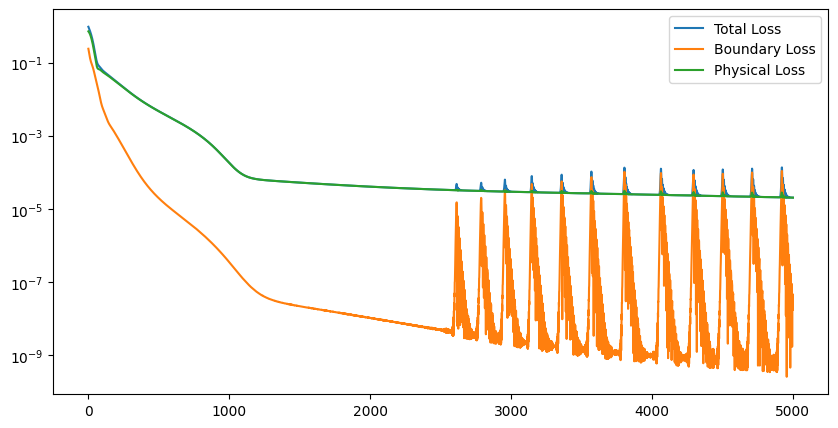

In [99]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(net.Losses['Loss'], label='Total Loss')
plt.plot(net.Losses['Boundary Loss'], label='Boundary Loss')
plt.plot(net.Losses['Physical Loss'], label='Physical Loss')
plt.yscale('log')
plt.legend()
plt.show()

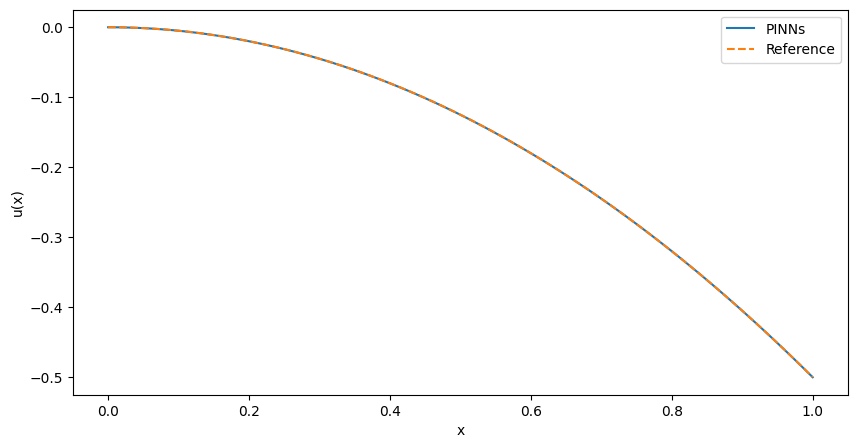

In [101]:
# Plot Solution
x = np.linspace(x_min, x_max, 100)
x = tf.constant(x, shape = (100, 1), dtype = DTYPE)
# pred pinns
u_pred = net.call(x)
u_pred = u_pred.numpy()
# reference solution
u_sol = net.u(x)
u_sol = u_sol.numpy()

plt.figure(figsize=(10, 5))
plt.plot(x, u_pred, label='PINNs')
plt.plot(x, u_sol, label='Reference', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()
